In [ ]:
!pip install transformers datasets rouge-score
!pip install bert-score

In [ ]:
!nvidia-smi

Tue Aug 13 13:00:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   56C    P8              13W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **TASKS**
***Develop and Analyze an LDA Model***

Build a Latent Dirichlet Allocation (LDA) model to uncover the underlying topics in the dataset. Evaluate the topics to gain insights into the thematic structure of the text.

***Evaluate and Compare T5 and BART Models***

Assess the performance of T5 and BART models on the abstractive summarization task using the EdinburghNLP/xsum dataset. This dataset is selected for its well-established use in abstractive summarization. The comparison will focus on how each model performs in generating summaries without additional fine-tuning.


# **High-Level Index of the Notebook**
**Dataset Analysis**

* Explore and understand the dataset, including its characteristics and structure.

**Part 1:**
**Create an LDA model to uncover and visualize the main topics in the dataset.**

*   Preprocess the Dataset:
Prepare the data for LDA model training.

*  Conduct Experiments:
Perform various experiments to explore the dataset and initial models.
Develop and Visualize the LDA Model

**Part 2:**

**Evaluate T5 and BART Models**

* Perform experiments with T5 and BART models on the abstractive summarization task using the EdinburghNLP/xsum dataset.

* Evaluate model performance using metrics such as ROUGE, BERTScore, METEOR, and Human Evaluation.

* Summarize the findings and provide a conclusion

# **DATASET ANALYSIS**

## **Dataset Anaylsis Pipeline**

1. Observe the dataset, see if it is clean like it is indicated

2. Investigate counts of sentencesi words, characters, stop words and punctuations. Implementation adapted from: https://medium.com/swlh/text-summarization-guide-exploratory-data-analysis-on-text-data-4e22ce2dd6ad

3. Create word clouds of documents and compare it with the word cloud of summary to get an overview of reference summaries


The dataset is https://huggingface.co/datasets/EdinburghNLP/xsum, I chose this dataset because it is a popular dataset for abstractive summarization

**LOAD THE DATA**

Due to limited computation resources the dataset is truncated. The dataset is shuffled before truncation to increase randomness.

**Dataset Characteristics:**

Train size: 15k, val size: 3k, test size: 3k

Reference summaries are all indicated to be 1 sentence lengthed. The summary is abstract summarization

In [ ]:
!pip install tabulate

In [ ]:
from datasets import load_dataset

# Load your dataset (replace 'dataset_name' and 'split' with your dataset details)
ds_train_full = load_dataset('EdinburghNLP/xsum', split='train')

ds_val_full = load_dataset('EdinburghNLP/xsum', split='validation')

ds_test_full = load_dataset('EdinburghNLP/xsum', split='test')

# Define sizes for train, validation, and test sets
train_size = 15000
val_size = 3000
test_size = 3000

# Shuffle the datasets
train_shuffled = ds_train_full.shuffle(seed=42)  # seed for reproducibility
val_shuffled = ds_val_full.shuffle(seed=42)      # seed for reproducibility
test_shuffled = ds_test_full.shuffle(seed=42)    # seed for reproducibility


# Truncate the dataset after shuffling
train_ds = train_shuffled.select(range(train_size))
val_ds = val_shuffled.select(range(val_size))
test_ds = test_shuffled.select(range(test_size))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

**1. Observe the dataset**

The dataset was indicated to be clean and it is also seen as clean. Each summary has 1 sentence (indicated in dataset card)

In [ ]:
from datasets import load_dataset

#print the first 5 elements
for i,element in enumerate(val_ds):
  if i == 5:
    break

  print(f"The original document:\n {element['document']}")
  print(f"The reference summary:\n {element['summary']}")
  print()
  print()



The original document:
 Patrick Joseph Connors, 59, his son Patrick Dean Connors, 39, and nephew William Connors, 36, denied requiring a person to perform forced or compulsory labour between 2010 and 2013.
They were convicted by a jury at Cardiff Crown Court on Tuesday.
Connors senior was jailed for 14 years, Patrick Dean for six-and-a-half years and William for four years.
Patrick Joseph Connors' son-in-law Lee Carbis, 34, who was cleared of forced labour, but found guilty of kidnap, was jailed for two-and-a-half years.
Catrin Evans, of the Crown Prosecution Service in Wales, said the men were guilty of "exploiting and controlling" their vulnerable victim in a "callous manner over a prolonged period of time".
'Modern slavery' victim 'emotionally broken'
The Connors kept Michael Hughes, 46, in "appalling conditions" in south Wales and paid him less than £10 a day for years.
He said: "I am over the moon at today's verdict. Both myself and my family can now move on and I am so happy to h

**2. Investigate counts**

In [ ]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from tabulate import tabulate

# Download NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Define punctuation characters
punc = string.punctuation

# Define stopwords using NLTK's English stopwords list
stopwords = set(stopwords.words('english'))

def count_stopwords(text, stopwords):
    ''' Return the number of stopwords in the text
        Input:
            - text: string
            - stopwords: set of strings, containing the stopwords
        Output:
            - int, number of stopwords in the text argument
    '''
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w.lower() in stopwords]
    return len(stopwords_x)

def split_sentences(text):
    ''' Split text into sentences
        Input:
            - text: string
        Output:
            - list of strings, where each string is a sentence
    '''
    return sent_tokenize(text)

# Example of how to apply these functions to your dataset
# Assuming `val_ds` is a pandas DataFrame containing 'summary' and 'document' columns

# Create new variables based on EDA
dataset = {}

# Convert the Dataset object to a pandas DataFrame
import pandas as pd
val_df = pd.DataFrame(val_ds)

# Number of sentences
dataset['sum_sentence_count'] = val_df['summary'].apply(lambda x: len(split_sentences(x)))
dataset['doc_sentence_count'] = val_df['document'].apply(lambda x: len(split_sentences(x)))

# Number of words
dataset['sum_word_count'] = val_df['summary'].apply(lambda x: len(x.split()))
dataset['doc_word_count'] = val_df['document'].apply(lambda x: len(x.split()))

# Number of characters (excluding spaces)
dataset['sum_char_count'] = val_df['summary'].apply(lambda x: len(x.replace(" ", "")))
dataset['doc_char_count'] = val_df['document'].apply(lambda x: len(x.replace(" ", "")))

# Word density
dataset['sum_word_density'] = dataset['sum_word_count'] / (dataset['sum_char_count'] + 1)
dataset['doc_word_density'] = dataset['doc_word_count'] / (dataset['doc_char_count'] + 1)

# Sentence density
dataset['sum_sentence_density'] = dataset['sum_sentence_count'] / (dataset['sum_word_count'] + 1)
dataset['doc_sentence_density'] = dataset['doc_sentence_count'] / (dataset['doc_word_count'] + 1)

# Number of punctuation marks
dataset['sum_punc_count'] = val_df['summary'].apply(lambda x: len([a for a in x if a in punc]))
dataset['doc_punc_count'] = val_df['document'].apply(lambda x: len([a for a in x if a in punc]))

# Number of stopwords
dataset['doc_stopw_count'] = val_df['document'].apply(lambda x: count_stopwords(x, stopwords))
dataset['sum_stopw_count'] = val_df['summary'].apply(lambda x: count_stopwords(x, stopwords))

# Stopword density
dataset['sum_stopw_density'] = dataset['sum_stopw_count'] / (dataset['sum_word_count'] + 1)
dataset['doc_stopw_density'] = dataset['doc_stopw_count'] / (dataset['doc_word_count'] + 1)

# Converting the dictionary to a DataFrame (optional, depending on your use case)
dataset_df = pd.DataFrame(dataset)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Despite the difference in length, both maintain similar word and sentence densities. However, documents contain more punctuation and stopwords, indicating greater complexity.**

In [ ]:
# Calculate the summary (average) for each column
summary_table = pd.DataFrame(dataset_df.mean(), columns=['Average Value']).reset_index()
summary_table.columns = ['Metric', 'Average Value']

# Display the summary table using tabulate for a prettier output
print(tabulate(summary_table, headers='keys', tablefmt='fancy_grid'))

╒════╤══════════════════════╤═════════════════╕
│    │ Metric               │   Average Value │
╞════╪══════════════════════╪═════════════════╡
│  0 │ sum_sentence_count   │       1         │
├────┼──────────────────────┼─────────────────┤
│  1 │ doc_sentence_count   │      18.905     │
├────┼──────────────────────┼─────────────────┤
│  2 │ sum_word_count       │      21.172     │
├────┼──────────────────────┼─────────────────┤
│  3 │ doc_word_count       │     376.232     │
├────┼──────────────────────┼─────────────────┤
│  4 │ sum_char_count       │     105.703     │
├────┼──────────────────────┼─────────────────┤
│  5 │ doc_char_count       │    1857.51      │
├────┼──────────────────────┼─────────────────┤
│  6 │ sum_word_density     │       0.199433  │
├────┼──────────────────────┼─────────────────┤
│  7 │ doc_word_density     │       0.20256   │
├────┼──────────────────────┼─────────────────┤
│  8 │ sum_sentence_density │       0.0480392 │
├────┼──────────────────────┼───────────

**3.Investigate wordclouds**

In [ ]:
!pip install wordcloud matplotlib

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def generate_wordcloud(text, title=None):
    """Generate and display a word cloud from a given text."""
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis labels
    if title:
        plt.title(title, fontsize=16)
    plt.show()

**From the wordclouds it can be seen that summaries deliver a concise description of the article**

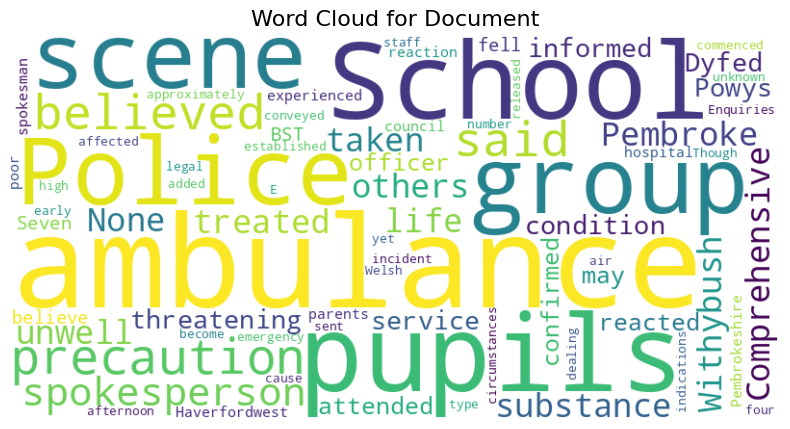

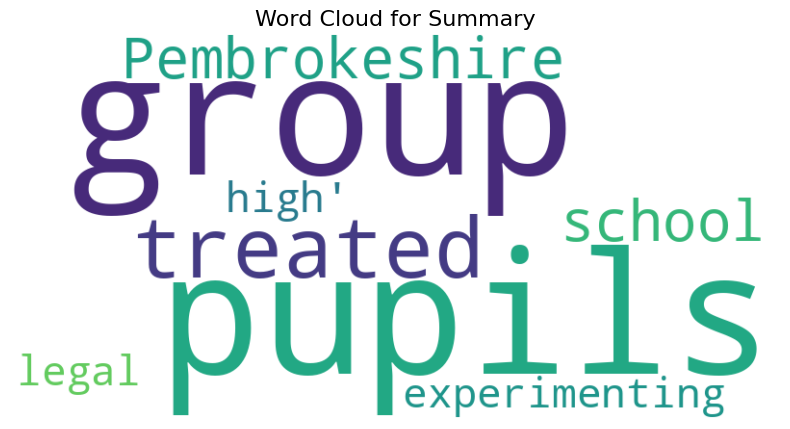

In [ ]:
example = val_ds[5]
document_text = example["document"]
summary_text = example["summary"]

# Generate word cloud for document text
generate_wordcloud(document_text, title="Word Cloud for Document")

# Generate word cloud for summary text
generate_wordcloud(summary_text, title="Word Cloud for Summary")

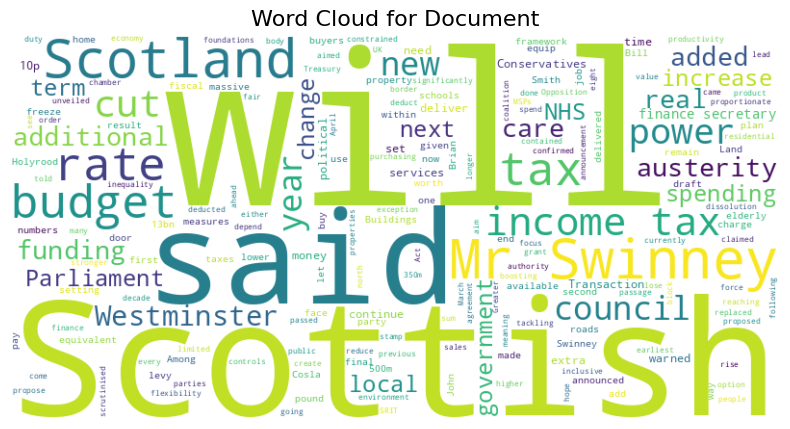

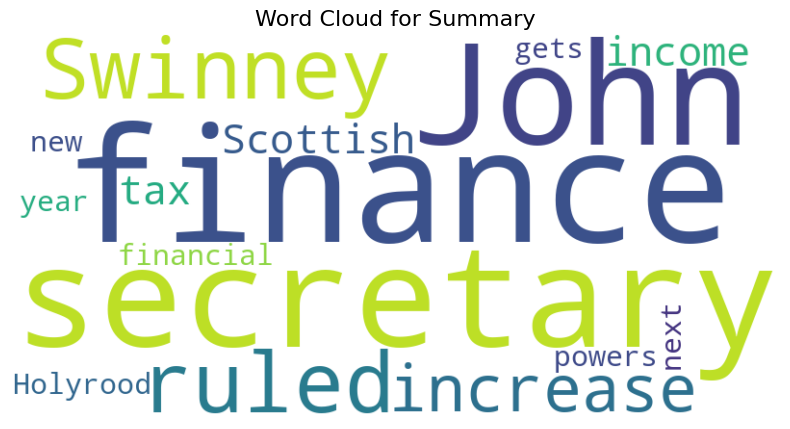

In [ ]:
example2 = val_ds[80]
document_text2 = example2["document"]
summary_text2 = example2["summary"]

# Generate word cloud for document text
generate_wordcloud(document_text2, title="Word Cloud for Document")

# Generate word cloud for summary text
generate_wordcloud(summary_text2, title="Word Cloud for Summary")

# **PART1** : LDA

Latent Dirichlet Allocation (LDA) is a statistical model used for topic modeling and text mining. The core idea is to infer the latent (hidden) topic structure that best explains the observed words in the documents.

Preprocessing is crucial before feeding data into the LDA to come up with better representations

#**PREPROCESSING PIPELINE FOR LDA:**

**Standardization:**
  Convert the text to lowercase.
  Remove newline characters and excess whitespace.

**Tokenization:**
  Split the text into individual words (tokens). Simple word_tokenize is used. Although there are more advanced tokenizers, I have seen that they are not used in LDA represantations and word_tokenize is the most common approach

**Removal of Non-Alphabetic Tokens:**
  Filter out tokens that are not alphabetic

**Stopword Removal:**
  Remove common stopwords (e.g., "the", "and") to focus on meaningful words.

**Part-of-Speech (POS) Tagging and Lemmatization:**
  Apply POS tagging to assign grammatical tags to each token.
  Lemmatize tokens based on their POS tags to reduce them to their base forms.

**Bigram and Trigram Detection:**
  Identify bigrams (two-word phrases) and trigrams (three-word phrases) in the text to capture multi-word expressions.

**Dictionary Creation:**
  Create a dictionary from the preprocessed texts, filtering out words that appear too infrequently or too frequently.

**Bag-of-Words (BoW) Model:**
  Convert the preprocessed texts into a Bag-of-Words (BoW) representation, where each text is represented as a vector of word counts.

In [ ]:
!pip3 install pyLDAvis # For visualizing topic models
import os
import re
import nltk
import pyLDAvis
import pyLDAvis.gensim
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel, TfidfModel
from gensim.models.phrases import Phrases, Phraser

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

In [ ]:
# Helper function for POS tagging to get WordNet POS tags
def get_wordnet_pos_tags(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Preprocessing function
def preprocess_data(text):
    # Standardize text to lowercase and remove unwanted characters
    clean_txt = re.sub(r'\n', ' ', text.lower())
    clean_txt = re.sub(r'\s+', ' ', clean_txt).strip()

    # Tokenize text
    tokens = word_tokenize(clean_txt)

    # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]

    # Remove stopwords
    stop_words = stopwords.words('english')
    tokens = [word for word in tokens if word not in stop_words]

    # POS tagging and lemmatization
    lemmatizer = WordNetLemmatizer()
    pos_tags = nltk.pos_tag(tokens)
    lemma_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos_tags(pos_tag)) for token, pos_tag in pos_tags]

    return lemma_tokens

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
preprocessed_texts = []
for data in train_ds:
    preprocessed_text = preprocess_data(data['document'])
    preprocessed_texts.append(preprocessed_text)


# Identify bigrams and trigrams
bigram = Phrases(preprocessed_texts, min_count=5, threshold=100)  # Detect bigrams
trigram = Phrases(bigram[preprocessed_texts], threshold=100)      # Detect trigrams
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Apply bigrams and trigrams to the texts
preprocessed_texts = [trigram_mod[bigram_mod[text]] for text in preprocessed_texts]

# Create a dictionary representation of the texts
dictionary = corpora.Dictionary(preprocessed_texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)  # Filter out extremes

# Create the Bag-of-Words (BoW) model
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel, LdaModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=4,passes = None,iterations = None):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f"Implementing with num_topics = {num_topics}")
        if passes == None:
            model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        else:
            model = LdaModel(corpus=corpus,id2word=dictionary,random_state=42,num_topics=num_topics,passes=passes,iterations=iterations)

        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        model_list.append(model)

    return model_list, coherence_values

def plot(coherence_values,start = 2,limit = 40,step = 4,):
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Score vs. Number of Topics")
    plt.legend(["Coherence Values"], loc='best')
    plt.show()

# Define parameters
start = 2
limit = 40
step = 4

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **APPLY EXPERIMENTS TO FIND THE OPTIMUM TOPIC NUMBER**

**Coherence** is a metric used to evaluate the quality of topics generated by LDA models. It measures the degree of semantic similarity between the top words in each topic. A higher coherence score indicates that the words within a topic are more related to each other, suggesting that the topics are more meaningful and interpretable. By experimenting with different numbers of topics and observing their coherence scores, one can identify the optimal number of topics that yields the most coherent and useful topics for the given dataset.


 From the plot below, it is seen that topic number in the interval 15-20 maximized the coherence score. That topic number is 18 in the experiment.

 However, the warning "training might not converge; consider increasing the number of passes or iterations to improve accuracy" indicates the model is not updating itself properly.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Implementing with num_topics = 2


Implementing with num_topics = 6


Implementing with num_topics = 10


Implementing with num_topics = 14


Implementing with num_topics = 18


Implementing with num_topics = 22


Implementing with num_topics = 26


Implementing with num_topics = 30


Implementing with num_topics = 34


Implementing with num_topics = 38


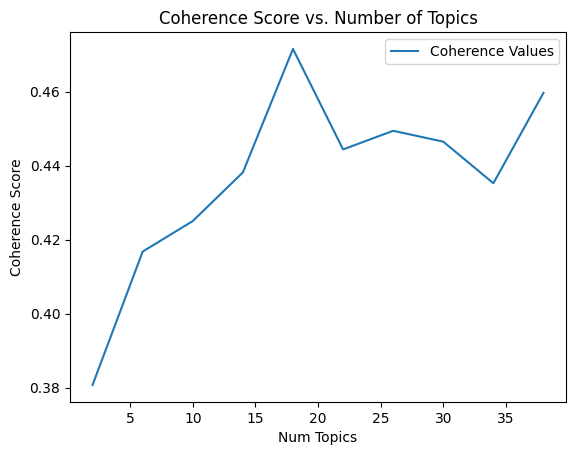

In [ ]:
# Compute coherence values
model_list, coherence_values = compute_coherence_values(dictionary, corpus, preprocessed_texts, limit, start, step)
plot(coherence_values)

# **HOW TO JUDGE THE LDA MODEL FROM pyLDAvis VISUALIZATION:**

**Avoid Overlapping Topics:**

Topics should be well-separated with minimal overlap. Overlapping circles suggest that the topics are too similar or indistinct.

**Avoid Scattered Topics:**

Topics should not be excessively scattered. Scattered topics indicate that the model might be too granular or not capturing coherent themes.

# **Create the topic model that performed best: Topic model 18**

Despite being the best-performing topic model accord. to the graph and the coherence value, the visualization reveals that the topic bubbles are clustered too closely together with significant overlap.

A warning had already indicated that the model was not updating correctly, which justifies the below visualization's bad performance.



In [ ]:
# num topics 18 has a peak, build LDA with that
lda_model = model_list[4]
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.112716 -0.069349       1        1  11.481479
9     -0.078078  0.007753       2        1   7.870027
15    -0.095267  0.086799       3        1   7.591468
5      0.154397 -0.005394       4        1   7.490334
7     -0.102394 -0.001366       5        1   6.725231
10    -0.084832  0.013751       6        1   6.352725
12     0.165338 -0.013983       7        1   6.272152
8     -0.073735  0.138612       8        1   6.158047
4     -0.085928 -0.048048       9        1   5.822797
17     0.016514  0.025711      10        1   5.806155
1     -0.076128 -0.153531      11        1   5.697515
2     -0.062331  0.199124      12        1   5.337356
3      0.260602  0.071478      13        1   4.201793
16    -0.040583 -0.025817      14        1   3.514249
0      0.059767 -0.019381      15        1   3.449539
13    -0.038329 -0.050125      16        1   2.937607
11     0.186217 -0.042794      17        1   1.970503
6      0.007483 -0.113442      18        1   1.321022, topic_info=       Term          Freq         Total Category  logprob  loglift
113      mr  16748.000000  16748.000000  Default  30.0000  30.0000
828  police   6981.000000   6981.000000  Default  29.0000  29.0000
337    game   5644.000000   5644.000000  Default  28.0000  28.0000
387  player   4382.000000   4382.000000  Default  27.0000  27.0000
339    goal   3440.000000   3440.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
609    last    129.361361   8695.947726  Topic18  -5.6030   0.1188
443    week    120.539597   4704.374391  Topic18  -5.6736   0.6625
585    come    121.602450   8021.570063  Topic18  -5.6649   0.1376
380     one    115.978222  12399.260453  Topic18  -5.7122  -0.3452
33    could    111.679869   8086.128415  Topic18  -5.7500   0.0445

[1632 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
19360      3  0.967494           abduction
5746       3  0.962707            abdullah
3883       1  0.063487            aberdeen
3883       3  0.003432            aberdeen
3883       4  0.005148            aberdeen
...      ...       ...                 ...
11258      7  0.937939  zlatan_ibrahimovic
13576      9  0.888940                 zoo
13576     10  0.064068                 zoo
13576     12  0.032034                 zoo
17820      6  0.957258                zuma

[10047 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 10, 16, 6, 8, 11, 13, 9, 5, 18, 2, 3, 4, 17, 1, 14, 12, 7])

# **Train Again With New Parameters**

Lets try to train another model with specifying the iteration number and passes . The number should be increased for possibly better results but due to limited sources 10 passes and 400 iterations are used in the first step.

Since no warnings are given it can be concluded that model is updating itself properly and the parameters don't strictly need an update.

It is seen that the graph keeps on increasing until a point. That point (topic number 14)  is the best performing topic number accord. to the relation between coherence and LDA MODEL. Additionally it is also in the increasing part of the graph (see topic number 34's bad performance below)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Implementing with num_topics = 2
Implementing with num_topics = 6
Implementing with num_topics = 10
Implementing with num_topics = 14
Implementing with num_topics = 18
Implementing with num_topics = 22
Implementing with num_topics = 26
Implementing with num_topics = 30
Implementing with num_topics = 34
Implementing with num_topics = 38


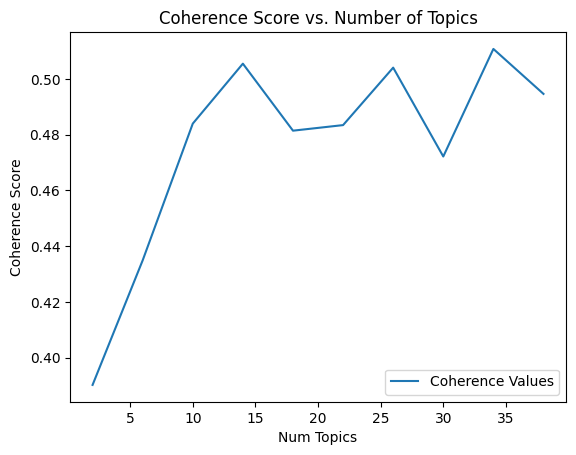

In [ ]:
from gensim.models import CoherenceModel

# Define the parameters
passes = 10
iterations = 400

model_list1, coherence_values1 = compute_coherence_values(dictionary=dictionary,corpus=corpus, texts=preprocessed_texts, limit=limit, start=start, step=step,passes = passes,iterations = iterations)
plot(coherence_values1)

In [ ]:
print(coherence_values1[2]) # num topics = 10
print(coherence_values1[3]) # num_topics = 14
lda_model = model_list1[3]

0.48399505313867824
0.5055230709630595


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


#**Visualization of the Best LDA model: topic number 14**

It can be seen that the bubbles have less overlapping s and is distributed more uniformly in the space. But these observations are not enough, also words that are grouped together should lead to a coherent structure

# **ANALYZING TOPICS**
There are 14 topics detected by the model. The below topics are coherent accord. to the keywords indicated by the model:

1 - GENERAL SPORTS

2- POLITICS

3- ENTERTAINMENT

5- CRIME

6- INTERNATIONAL POLITICS

7- BUSINESS & ECONOMY

8 - INTERNATIONAL CRIME

9 - FOOTBALL

12- SCIENCE

13- INTERNATIONAL SPORTS (olimpycs)

14- WORLD NEWS

The word distribution of the topics that I didn't label was not as coherent as the other ones, a more complex model i.e with higher iterations can be trained to get better topic representations

In [ ]:
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.045549 -0.061966       1        1  13.655612
8     -0.119565 -0.017374       2        1  13.054080
11    -0.037611 -0.032447       3        1  12.419245
0     -0.153165 -0.033514       4        1  10.098889
6     -0.025939  0.170312       5        1   9.073096
10    -0.152447 -0.012109       6        1   7.717587
2     -0.118076 -0.103944       7        1   7.002389
9     -0.046569  0.158606       8        1   5.615483
5      0.282881  0.035395       9        1   4.510921
7      0.021082  0.237792      10        1   4.414780
12    -0.035904 -0.007501      11        1   4.083075
13    -0.100520 -0.147487      12        1   3.564892
3      0.100717 -0.104812      13        1   2.775754
1      0.339569 -0.080949      14        1   2.014197, topic_info=        Term          Freq         Total Category  logprob  loglift
113       mr  16534.000000  16534.000000  Default  30.0000  30.0000
828   police   6750.000000   6750.000000  Default  29.0000  29.0000
337     game   5621.000000   5621.000000  Default  28.0000  28.0000
1289   woman   3645.000000   3645.000000  Default  27.0000  27.0000
339     goal   3464.000000   3464.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
3396  george    168.069858    514.378038  Topic14  -5.7631   2.7864
211    first    217.035123   8800.313436  Topic14  -5.5074   0.2025
3384   black    171.422373   1029.690097  Topic14  -5.7433   2.1121
1228     ben    160.451671    493.572593  Topic14  -5.8094   2.7813
1079   stage    162.306572   1334.005278  Topic14  -5.7980   1.7985

[1060 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
19240     11  0.992223  aberystwyth
452        2  0.087721        abuse
452        5  0.869433        abuse
452        6  0.042195        abuse
14287     12  0.995546           ac
...      ...       ...          ...
3824       5  0.032707    yorkshire
3824      10  0.163535    yorkshire
3824      13  0.796860    yorkshire
14370     12  0.986795           yr
5618      13  0.994118     zimbabwe

[3440 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 12, 1, 7, 11, 3, 10, 6, 8, 13, 14, 4, 2])

# **VISUALIZATION OF BAD LDA MODELS**

To visualize how we don't want our LDA model to be, let's visualize topic numbers 10 and 38 from the above graph.

**For the first visualization (topic number 10)**: it is seen that there is significant overlap in the upper right corner which is not wanted

**For the second visualization (topic number 34)**:there is overlap but also topics are too scattered around the space. Which is also not wanted.

Also, from the graph it was seen that 34 actually had a peak. But the graph was not strictly increasing around that point. So it can be concluded that it is always better to generate a graph rather than examining coherence numbers only

In [ ]:
# TOPIC NUMBER = 10
lda_model1 = model_list1[2]
pyLDAvis.enable_notebook()
vis1 = pyLDAvis.gensim.prepare(lda_model1, corpus, dictionary)
vis1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.120764  0.075418       1        1  17.867369
0      0.149607  0.077448       2        1  14.538966
4      0.058443 -0.107978       3        1  14.250396
6      0.049732  0.051521       4        1  13.808120
3      0.105069 -0.003448       5        1  11.260067
2      0.125479  0.072765       6        1   9.404436
9      0.060690  0.084301       7        1   8.220656
5     -0.170603 -0.276685       8        1   4.907249
1     -0.079494 -0.196496       9        1   4.332806
7     -0.419687  0.223153      10        1   1.409936, topic_info=        Term          Freq         Total Category  logprob  loglift
113       mr  16455.000000  16455.000000  Default  30.0000  30.0000
828   police   6716.000000   6716.000000  Default  29.0000  29.0000
337     game   5538.000000   5538.000000  Default  28.0000  28.0000
339     goal   3338.000000   3338.000000  Default  27.0000  27.0000
387   player   4232.000000   4232.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
1250    lane    114.496238    269.456377  Topic10  -5.7902   3.4058
1079   stage    134.555799   1318.243060  Topic10  -5.6288   1.9795
3398  injury    133.228952   1702.364418  Topic10  -5.6387   1.7139
1381      eu    130.527782   2638.642922  Topic10  -5.6592   1.2552
2032     gmt    122.773338    716.967025  Topic10  -5.7204   2.4969

[786 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
19240      9  0.989819  aberystwyth
14287     10  0.992198           ac
3428       2  0.118938     accident
3428       4  0.306417     accident
3428       7  0.066525     accident
...      ...       ...          ...
5784       7  0.994992        yemen
13371     10  0.998861           yn
8452      10  0.989457    york_city
14370     10  0.989946           yr
13576      4  0.996183          zoo

[2171 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 5, 7, 4, 3, 10, 6, 2, 8])

In [ ]:
#TOPIC NUMBER = 34
lda_model2 = model_list1[8]
pyLDAvis.enable_notebook()
vis2 = pyLDAvis.gensim.prepare(lda_model2, corpus, dictionary)
vis2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16     0.179924  0.016852       1        1  9.975843
8      0.158674 -0.071105       2        1  9.355168
20     0.166651 -0.104629       3        1  7.705464
4      0.163135  0.189687       4        1  6.138108
21     0.105898 -0.074616       5        1  5.525175
11     0.155955  0.068218       6        1  5.266111
28     0.107912  0.201044       7        1  4.286784
32     0.099851 -0.109002       8        1  4.259621
2      0.131129 -0.098235       9        1  4.219705
9      0.068168 -0.090926      10        1  3.693823
17     0.079782  0.195260      11        1  3.416145
10     0.104417 -0.154320      12        1  3.411973
0      0.114828 -0.087470      13        1  3.340363
5     -0.040419  0.224081      14        1  3.284472
30     0.039323 -0.059609      15        1  2.528345
18     0.036330  0.066653      16        1  2.239249
23    -0.004429 -0.169963      17        1  2.100307
22    -0.018311  0.042239      18        1  1.923950
33     0.044348  0.083176      19        1  1.837294
29     0.045611  0.205907      20        1  1.737478
31     0.035621  0.086019      21        1  1.729158
25    -0.044126 -0.012873      22        1  1.554976
13    -0.075759 -0.157923      23        1  1.521721
6     -0.015442 -0.092074      24        1  1.468993
26    -0.005542 -0.100334      25        1  1.427945
19    -0.061709  0.013807      26        1  1.110560
15    -0.099544 -0.075462      27        1  0.992650
12    -0.106228  0.000295      28        1  0.851420
14    -0.186926  0.025107      29        1  0.657095
3     -0.185863  0.013103      30        1  0.574358
1     -0.264799  0.078205      31        1  0.536725
7     -0.273035 -0.020584      32        1  0.486608
24    -0.260720  0.017519      33        1  0.433496
27    -0.194704 -0.048049      34        1  0.408918, topic_info=           Term          Freq         Total Category  logprob  loglift
113          mr  16496.000000  16496.000000  Default  30.0000  30.0000
979           u   8242.000000   8242.000000  Default  29.0000  29.0000
267         bbc   5186.000000   5186.000000  Default  28.0000  28.0000
828      police   6766.000000   6766.000000  Default  27.0000  27.0000
292        club   3981.000000   3981.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
1730      alert     90.163976    339.724206  Topic34  -4.7913   4.1729
980     website    107.252179    953.849416  Topic34  -4.6178   3.3141
1605  highlight     86.005915    560.170190  Topic34  -4.8386   3.6256
1452     medium     82.075003   1308.897563  Topic34  -4.8853   2.7301
5769    nuclear     74.649513    353.632047  Topic34  -4.9802   3.9440

[2354 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
8548      20  0.059019       abbott
8548      30  0.929556       abbott
8581      30  0.980449          abc
19360     24  0.974004    abduction
19240     28  0.988443  aberystwyth
...      ...       ...          ...
12724     11  0.980640       zambia
3674      31  0.986872         zika
5618      30  0.992796     zimbabwe
13576     24  0.990732          zoo
17820     26  0.974672         zuma

[8837 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 9, 21, 5, 22, 12, 29, 33, 3, 10, 18, 11, 1, 6, 31, 19, 24, 23, 34, 30, 32, 26, 14, 7, 27, 20, 16, 13, 15, 4, 2, 8, 25, 28])

# **PART2 COMPARING T5 AND BART ON ABSTRACTIVE SUMMARIZATION TASK WITHOUT FINE TUNING**

#**EXPERIMENTS PIPELINE**

Below is the high level pipeline used for conducting the experiments. Details
are included in each section.

**1- Preprocessing of the dataset**

The transformer models T5 and BART use their built-in tokenizers for handling input text. Given the dataset was clean, no additional preprocessing was needed. Tokenization was performed directly by the models, as manual preprocessing could reduce performance.

Adjustments made:

**T5**: Standard practice includes the prefix “summarize:” for summarization tasks, as recommended by T5 implementations.

**BART**: Tested with and without a summarization prefix to assess its impact. Both variations were evaluated on the validation set.

**2 - Parameter tuning for models to find the best parameters**

1. Generate summaries on validation set using different combinations of top p,top k and temperature.

2. Record the results for each experiment and print a subset of summaries for that experiment.

3. Display the results using rouge scores (a common metric for summarization, used for it's simpliciy)

4. Pick the best performing experiment by prioritizing rouge2 score.


**3- Generating summaries on the test set using parameters found above**
1.   Generate summaries using the parameters of best experiment from  parameter tuning

**4- Comparing two models with various metrics**
1. Compare models according to the following metrics:

      1.   Rouge Scores
      2.   Bert Scores
      3.   Human Evaluation (my evaluation)
      4.   Meteor Score










In [ ]:
!pip3 install torchvision
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


INITIALIZE MODELS, INITIALIZE THEIR TOKENIZERS

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load T5 tokenizer and model
t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-base").to(device)

# Initialize BART base model and tokenizer
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

# Set padding token for BART if necessary
bart_tokenizer.pad_token = bart_tokenizer.eos_token


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
MAX_NUM_SUMMARY_TOKENS_T5 = 512  # Maximum length for input sequences
MAX_NUM_LABEL_TOKENS_T5 = 150    # Maximum length for output sequences (summaries)
TRUNCATE_T5_SUMMARY = True       # Whether to truncate input sequences
TRUNCATE_T5_LABEL = True         # Whether to truncate output sequences

MAX_NUM_SUMMARY_TOKENS_BART = 512  # Maximum length for input sequences
MAX_NUM_LABEL_TOKENS_BART = 150  # Maximum length for output sequences (summaries)
TRUNCATE_BART_SUMMARY = True  # Whether to truncate input sequences
TRUNCATE_BART_LABEL = True  # Whether to truncate output sequences

NUM_BEAMS = 4



# **1 - PREPROCESS THE DATASET with Transfomer Tokenizers**

In [ ]:
# Preprocess the dataset
def preprocess_t5(examples):
    inputs = ["summarize: " + doc for doc in examples["document"]]
    tokenized_inputs = t5_tokenizer(inputs, max_length=MAX_NUM_SUMMARY_TOKENS_T5, truncation=TRUNCATE_T5_SUMMARY)

    # Setup the tokenizer for targets
    with t5_tokenizer.as_target_tokenizer():
        labels = t5_tokenizer(examples["summary"], max_length=MAX_NUM_LABEL_TOKENS_T5, truncation=TRUNCATE_T5_LABEL)

    tokenized_inputs["labels"] = labels["input_ids"]
    return tokenized_inputs

train_t5_tokenized = train_ds.map(preprocess_t5, batched=True)
val_t5_tokenized = val_ds.map(preprocess_t5, batched=True)
test_t5_tokenized = test_ds.map(preprocess_t5, batched=True)

print(train_t5_tokenized)

# Set format for PyTorch ???
train_t5_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_t5_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_t5_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Dataset({
    features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 15000
})


In [ ]:
def preprocess_bart(examples,add_prefix = True):
    # Add a prefix for summarization
    if add_prefix:
      inputs = ["summarize: " + doc for doc in examples["document"]]
    else:
      inputs = [doc for doc in examples["document"]]

    # Tokenize the inputs
    tokenized_inputs = bart_tokenizer(inputs, max_length=MAX_NUM_SUMMARY_TOKENS_BART, truncation=TRUNCATE_BART_SUMMARY, padding="max_length")

    # Tokenize the labels
    with bart_tokenizer.as_target_tokenizer():
        labels = bart_tokenizer(examples["summary"], max_length=MAX_NUM_LABEL_TOKENS_BART, truncation=TRUNCATE_BART_LABEL, padding="max_length")

    # Ensure the labels are set correctly
    tokenized_inputs["labels"] = labels["input_ids"]
    return tokenized_inputs

# Apply preprocessing with batching
train_bart_tokenized = train_ds.map(preprocess_bart, batched=True)
val_bart_tokenized = val_ds.map(preprocess_bart, batched=True)
test_bart_tokenized = test_ds.map(preprocess_bart, batched=True)

# Set format for PyTorch
train_bart_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_bart_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_bart_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Apply preprocessing with add_prefix=False
train_bart_tokenized_wo_prefix = train_ds.map(lambda x: preprocess_bart(x, add_prefix=False), batched=True)
val_bart_tokenized_wo_prefix = val_ds.map(lambda x: preprocess_bart(x, add_prefix=False), batched=True)
test_bart_tokenized_wo_prefix = test_ds.map(lambda x: preprocess_bart(x, add_prefix=False), batched=True)

train_bart_tokenized_wo_prefix.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_bart_tokenized_wo_prefix.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_bart_tokenized_wo_prefix.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

**CREATE THE PIPELINE FOR EXPERIMENTS**

In [ ]:
def generate_summary(batch, model, tokenizer, max_length=150, temperature=1.0, top_p=0.95, top_k=50):
    summaries = []
    input_ids = batch["input_ids"]
    attention_masks = batch["attention_mask"]

    for i in range(len(input_ids)):
        current_tokens = torch.tensor(input_ids[i]).unsqueeze(0).to(device)  # Add batch dimension
        current_attention_mask = torch.tensor(attention_masks[i]).unsqueeze(0).to(device)  # Add batch dimension

        summary_encoded = model.generate(
            input_ids=current_tokens,
            attention_mask=current_attention_mask,
            max_length=max_length,
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            num_beams=NUM_BEAMS,
            early_stopping=True,
            do_sample=True
        )

        summary = tokenizer.decode(summary_encoded[0], skip_special_tokens=True)
        summaries.append(summary)

    return summaries

In [ ]:
# Define parameter ranges for tuning
temperatures = [0.7, 1.0, 1.2]
top_ps = [0.8, 0.9, 0.95]
top_ks = [20, 50, 100]

def iterate(model,tokenizer,dataset):
  # Example of tuning loop
  results = dict()
  for temp in temperatures:
      for p in top_ps:
          for k in top_ks:
              print(f"Testing parameters: temperature={temp}, top_p={p}, top_k={k}")

              # Generate summaries for validation set
              val_summaries = generate_summary(dataset, model, tokenizer, max_length=150, temperature=temp, top_p=p, top_k=k)

              results[f"t={temp},p={p},k={k}"] = val_summaries

              # Print results (just for demonstration)
              print(f"Generated summaries for temperature={temp}, top_p={p}, top_k={k}")
              print(val_summaries[:5])  # Print first 5 summaries for inspection

  return results

had to create a subset of validation set due to the limited computation capabilities.

In [ ]:
val_subset_t5 = val_t5_tokenized.select(range(100)) # Select the first 500 elements as a Dataset
val_subset_bart = val_bart_tokenized.select(range(100)) # Select the first 500 elements as a Dataset
val_subset_bart_wo_prefix = val_bart_tokenized_wo_prefix.select(range(100)) # Select the first 500 elements as a Dataset
val_subset_summaries = val_ds.select(range(100))["summary"]

# **DECODING STRATEGIES RECAP**

Decoding strategies play a crucial role in the quality of the generated outputs. Various parameters can be adjusted to optimize these decoding processes. Key parameters to consider include temperature, top-p, and top-k.

**Temperature**:
Temperature controls the randomness of predictions by scaling the logits before applying the softmax function. Adjusts the confidence of the model in its predictions.

***Increasing the Temperature***: When the temperature is increased, the probability distribution becomes more flattened. This leads to a wider range of possible outputs, making the generated text more diverse and creative. However, this also increases the likelihood of producing less coherent responses as the model becomes less certain in selecting the most probable tokens.

***Decreasing the Temperature***: Lowering the temperature results in a sharper distribution, concentrating probability mass on the most likely tokens. This leads to outputs that are more focused and deterministic, often producing safer and more repetitive text. While this can reduce the risk of incoherence, it may also result in less diversity and more repetitive outputs, which can be problematic in open-ended tasks.

**Top_k:**

Selects top k most probable tokens from the model's predictions at each step. This approach helps mitigate repetition (which is a problem in open ended tasks like abstractive summarization) by preventing the model from consistently choosing the highest-probability token


However relying solely on top_k metric can introduce problems:

***Early Stopping***: If the probability distribution is relatively uniform, a smaller k may prematurely eliminate valid tokens cutting of good choices too early.

***Late Stopping***: Conversely, if the probability distribution is highly skewed, a larger k may retain too many low-probability tokens, leading to less coherent tokens.

**Top-p:**

The top-p metric addresses the issues above by dynamically adjusts the range of choices based on the distribution of probabilities instead of picking a top fixed number

**CREATE FUNCTONS FOR EVALUATION**

In [ ]:
!pip install evaluate
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00


In [ ]:
# install evaluation dependencies
from rouge_score import rouge_scorer
import pandas as pd

In [ ]:
# candidates is a dictionary with K:V as "experiment name":[decoded summaries in a list]
def eval_scores(references, candidates,is_a_single_experiment = False) -> list:
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    results = []

    if is_a_single_experiment:
      exp_result = {
          "rouge1": 0.0,
          "rouge2": 0.0,
          "rougeL": 0.0,
          "data size": 0
      }

      for ref,generated in zip(references,candidates):
          score = scorer.score(ref, generated)

          exp_result["rouge1"] += score['rouge1'].fmeasure
          exp_result["rouge2"] += score['rouge2'].fmeasure
          exp_result["rougeL"] += score['rougeL'].fmeasure

          exp_result["data size"] += 1

      # Calculate the average scores
      exp_result["rouge1"] = exp_result["rouge1"] / exp_result["data size"]
      exp_result["rouge2"] = exp_result["rouge2"] / exp_result["data size"]
      exp_result["rougeL"] = exp_result["rougeL"] / exp_result["data size"]

      results.append(exp_result)

    # apply a different algorithm
    else:

      for exp in candidates:
          exp_result = {
              "exp.": exp,
              "rouge1": 0.0,
              "rouge2": 0.0,
              "rougeL": 0.0,
              "data size": 0
          }

          total_rouge1, total_rouge2, total_rougeL = 0, 0, 0

          for ref, cand in zip(references, candidates[exp]):
              score = scorer.score(ref, cand)

              exp_result["rouge1"] += score['rouge1'].fmeasure
              exp_result["rouge2"] += score['rouge2'].fmeasure
              exp_result["rougeL"] += score['rougeL'].fmeasure

              exp_result["data size"] += 1

          # Calculate the average scores
          exp_result["rouge1"] = exp_result["rouge1"] / exp_result["data size"]
          exp_result["rouge2"] = exp_result["rouge2"] / exp_result["data size"]
          exp_result["rougeL"] = exp_result["rougeL"] / exp_result["data size"]

          results.append(exp_result)

    return results


# **2 - PARAMETER TUNING FOR MODELS**

In this experiment, various combinations of temperature, top-k, and top-p were tested to observe their impact on the quality of generated summaries. The parameters tested included all combinations of:

* Temperatures: [0.7, 1.0, 1.2]
* Top-p values: [0.8, 0.9, 0.95]
* Top-k values: [20, 50, 100]


Due to computational limitations, only parameter combinations above were explored. These experiments can be extended to see how model behaves under different parameters. For example, it would be interesting to adjust temperature to get more creative results.

**Parameter Tuning for T5**

In [ ]:
t5_summaries = iterate(t5_model,t5_tokenizer,val_subset_t5)

Testing parameters: temperature=0.7, top_p=0.8, top_k=20


<ipython-input-18-64508cddc626>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tokens = torch.tensor(input_ids[i]).unsqueeze(0).to(device)  # Add batch dimension
<ipython-input-18-64508cddc626>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_attention_mask = torch.tensor(attention_masks[i]).unsqueeze(0).to(device)  # Add batch dimension


Generated summaries for temperature=0.7, top_p=0.8, top_k=20
["Connors senior was jailed for 14 years, his son for six-and-a-half years and nephew for four years. Connors' son-in-law Lee carbis, 34, was cleared of forced labour but found guilty of kidnap. he was jailed for two-and-a-half years.", 'hibs drew 1-1 with dumbarton in their premier league clash. a mistake from goalkeeper Alan Martin earned the visitors a point. a second-half penalty from Christian Nade and a superb finish from Robert Thomson earned the visitors a point.', 'kamiyah mobley, who was abducted in 1998, was found after a tip. authorities in Walterboro, south Carolina, have charged Gloria Williams, 51, with kidnapping. the biological family have been notified of the news.', 'the Global Slavery Index 2013 says India has the highest number of people living in slavery. Mauritania has the highest proportional figure with about 4% of its population enslaved. the index was compiled by australia-based rights organisation 

# **BART: Should the document include a prefix or not?**

For performing task summarization with BART, I saw two approaches and tested their performance:

1- Include a prefix "summarize:" before each document

2- Don't include a prefix

**Results**

For BART, an issue was observed when including the prefix "summarize:". The model unexpectedly included the prefix as the starting token in the generated summaries.

And if the generated summaries are observed (i.e see logs of  experiment 0.7, 0.8, 50) overall reduction in output quality was observed. it is obvious that BART generates more coherent summaries **without the prefix "summarize:**"

In [ ]:
# summaries with prefix "summarize:"
bart_summaries_w_prefix = iterate(bart_model,bart_tokenizer,val_subset_bart)

Testing parameters: temperature=0.7, top_p=0.8, top_k=20


<ipython-input-18-64508cddc626>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tokens = torch.tensor(input_ids[i]).unsqueeze(0).to(device)  # Add batch dimension
<ipython-input-18-64508cddc626>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_attention_mask = torch.tensor(attention_masks[i]).unsqueeze(0).to(device)  # Add batch dimension


Generated summaries for temperature=0.7, top_p=0.8, top_k=20
['summarize: Patrick Joseph Connors, 59, his son Patrick Dean Connors (pictured), 39, and nephew WilliamConnors, 36, denied requiring a person to perform forced or compulsory labour between 2010 and 2013. Credit:PAThey were convicted by a jury at Cardiff Crown Court on Tuesday.Patrick JosephConnors senior was jailed for 14 years, Patrick Dean for six-and-a-half years and William for four years.The court heard the three Connors kept Michael Hughes, 46, in "appalling conditions" in south Wales and paid him less than £10 a day for years before he was sent back to Scotland.The Connors\' son-in-law Lee Carbis, 34, who was', "summarize: The visitors were closing in on three points thanks to Christian Nade's first-half penalty and a fine finish from Robert Thomson.But Martin Boyle's late effort - after Daniel Harvie scored an own goal and James Keatings had a penalty saved - earned Hibs a point.A mistake from goalkeeper Alan Martin 

**Lets try and see the results without a prefix**

In [ ]:
# bart without a prefix
bart_summaries = iterate(bart_model,bart_tokenizer,val_subset_bart_wo_prefix)

Testing parameters: temperature=0.7, top_p=0.8, top_k=20


<ipython-input-18-64508cddc626>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tokens = torch.tensor(input_ids[i]).unsqueeze(0).to(device)  # Add batch dimension
<ipython-input-18-64508cddc626>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_attention_mask = torch.tensor(attention_masks[i]).unsqueeze(0).to(device)  # Add batch dimension


Generated summaries for temperature=0.7, top_p=0.8, top_k=20
['Patrick Joseph Connors (pictured), 59, his son Patrick Dean Connors, 39, and nephew WilliamConnors, 36, denied requiring a person to perform forced or compulsory labour between 2010 and 2013.They were convicted by a jury at Cardiff Crown Court on Tuesday.The three men were sentenced to 14 years in prison.Connors senior was jailed for 14 years, Patrick Dean for six-and-a-half years and William for four years.The court heard the Connors kept Michael Hughes, 46, in "appalling conditions" in south Wales and paid him less than £10 a day for years. Patrick Dean and William Connors were jailed for two years.Patrick JosephConnors\' son-in-law Lee', "The visitors were closing in on three points thanks to Christian Nade's first-half penalty and a fine finish from Robert Thomson.But Martin Boyle's late effort - after Daniel Harvie scored an own goal and James Keatings had a penalty saved - earned Hibs a point.A mistake from goalkeeper

**FIND THE BEST PERFORMING EXPERIMENT ON VALIDATION SET FOR T5 and BART**

For simplicity, I only tested parameter tuning experiments with the rouge metric. Which is a popular metric but is interested more in content overlap than semantic overlap. On the final evaluation of models, I used different methods that observe semantical overlap

I observed rouge1, rouge2 and rougeL metrics' results. Because our task, abstractive summarization often involves rephrasing, bigram matches can be a strong indicator of how well the model captures key information in a more natural or human-like manner.

For this reason **I prioritized ROUGE-2** metric and found the parameters that maximizes it and used those parameters in the test set

In [ ]:
t5_results = eval_scores(val_subset_summaries,t5_summaries)
t5_results = pd.DataFrame(t5_results)

In [ ]:
bart_results = eval_scores(val_subset_summaries,bart_summaries)
bart_results = pd.DataFrame(bart_results)

In [ ]:
def display_sorted(data:pd.DataFrame,key:str):
  data_sorted = data.sort_values(by=key, ascending=False)
  print(data_sorted)

**For T5:**

As seen from the table below:

Experiment indexed 16 maximized rouge2

Experiment indexed 25 maximized rouge1

Experiment indexed 26 maximized rougeL

**So parameters t=1.0,p=0.95,k=50 are picked for T5**


In [ ]:
display_sorted(t5_results,"rouge2")

                  exp.    rouge1    rouge2    rougeL  data size
16   t=1.0,p=0.95,k=50  0.198448  0.034694  0.133389        100
25   t=1.2,p=0.95,k=50  0.202179  0.034322  0.137933        100
19    t=1.2,p=0.8,k=50  0.198153  0.033242  0.136390        100
20   t=1.2,p=0.8,k=100  0.198577  0.032998  0.134351        100
18    t=1.2,p=0.8,k=20  0.192808  0.032454  0.131793        100
2    t=0.7,p=0.8,k=100  0.197834  0.032405  0.134978        100
8   t=0.7,p=0.95,k=100  0.198816  0.032166  0.136155        100
4     t=0.7,p=0.9,k=50  0.197495  0.031901  0.135968        100
15   t=1.0,p=0.95,k=20  0.192789  0.031897  0.134016        100
17  t=1.0,p=0.95,k=100  0.196819  0.031857  0.134638        100
22    t=1.2,p=0.9,k=50  0.197074  0.031410  0.137259        100
9     t=1.0,p=0.8,k=20  0.194436  0.030975  0.132073        100
10    t=1.0,p=0.8,k=50  0.195361  0.030969  0.134041        100
7    t=0.7,p=0.95,k=50  0.197092  0.030896  0.135147        100
26  t=1.2,p=0.95,k=100  0.199999  0.0308

In [ ]:
display_sorted(t5_results,"rouge1")

In [ ]:
display_sorted(t5_results,"rougeL")

**For Bart**

As seen from the table below:

Experiment indexed 2 maximized rouge2

Experiment indexed 26 maximized rouge1

Experiment indexed 2 maximized rougeL

**So parameters t=0.7,p=0.8,k=100 are picked for BART**

In [ ]:
display_sorted(bart_results,"rouge2")

                  exp.    rouge1    rouge2    rougeL  data size
2    t=0.7,p=0.8,k=100  0.162633  0.030094  0.103105        100
1     t=0.7,p=0.8,k=50  0.162113  0.029714  0.100487        100
17  t=1.0,p=0.95,k=100  0.161298  0.029714  0.100795        100
25   t=1.2,p=0.95,k=50  0.162084  0.029340  0.099273        100
3     t=0.7,p=0.9,k=20  0.161815  0.029305  0.101116        100
4     t=0.7,p=0.9,k=50  0.162563  0.029236  0.102154        100
26  t=1.2,p=0.95,k=100  0.162909  0.029212  0.099993        100
5    t=0.7,p=0.9,k=100  0.160513  0.029063  0.100831        100
21    t=1.2,p=0.9,k=20  0.161509  0.028883  0.100598        100
9     t=1.0,p=0.8,k=20  0.162193  0.028745  0.100082        100
0     t=0.7,p=0.8,k=20  0.161460  0.028622  0.101727        100
12    t=1.0,p=0.9,k=20  0.161954  0.028438  0.100551        100
22    t=1.2,p=0.9,k=50  0.158515  0.028371  0.099009        100
20   t=1.2,p=0.8,k=100  0.159907  0.028288  0.098823        100
10    t=1.0,p=0.8,k=50  0.160556  0.0281

In [ ]:
display_sorted(bart_results,"rouge1")

In [ ]:
display_sorted(bart_results,"rougeL")

# **2- Generating Summaries on the Test Set Using the Best Performing Parameters**

In [ ]:
# t=1.0,p=0.95,k=50
t5_summaries = generate_summary(test_t5_tokenized,t5_model,t5_tokenizer,temperature = 1.0, top_p = 0.95, top_k = 50)

<ipython-input-18-64508cddc626>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tokens = torch.tensor(input_ids[i]).unsqueeze(0).to(device)  # Add batch dimension
<ipython-input-18-64508cddc626>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_attention_mask = torch.tensor(attention_masks[i]).unsqueeze(0).to(device)  # Add batch dimension


In [ ]:
t5_scores = eval_scores(test_ds["summary"],t5_summaries,True)
print(t5_scores)

[{'rouge1': 0.20254320928809064, 'rouge2': 0.031583782744135355, 'rougeL': 0.13747294449807376, 'data size': 3000}]


In [ ]:
# t=0.7,p=0.8,k=100
bart_summaries = generate_summary(test_bart_tokenized_wo_prefix,bart_model,bart_tokenizer,temperature = 0.7, top_p = 0.8, top_k = 100)

<ipython-input-18-64508cddc626>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tokens = torch.tensor(input_ids[i]).unsqueeze(0).to(device)  # Add batch dimension
<ipython-input-18-64508cddc626>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_attention_mask = torch.tensor(attention_masks[i]).unsqueeze(0).to(device)  # Add batch dimension


In [ ]:
bart_scores = eval_scores(test_ds["summary"],bart_summaries,True)
print(bart_scores)

[{'rouge1': 0.1582768161923418, 'rouge2': 0.028948323572566152, 'rougeL': 0.10083725634610793, 'data size': 3000}]


# **ROUGE SCORE**

ROUGE scores are indicators of content overlap. From the table above it is seen that T5 consistently outperforms BART in all ROUGE metrics. If performance varied, ROUGE-2 would be the metric of interest due to its focus on capturing key phrases and relationships.

**It indicates that T5 generates summaries with more content coverage and alignment with the reference summary comparing to BART**.

**Since abstractive summarization is an open ended task. Content overlap is not enough and more metrics are needed:**




In [ ]:
from tabulate import tabulate

rouge_scores = []
t5_scores[0]["model"] = "t5"
bart_scores[0]["model"] = "bart"

rouge_scores.append(t5_scores[0])
rouge_scores.append(bart_scores[0])

rouge_scores = pd.DataFrame(rouge_scores)

print(tabulate(rouge_scores, headers='keys', tablefmt='pretty'))



+---+---------------------+----------------------+---------------------+-----------+-------+
|   |       rouge1        |        rouge2        |       rougeL        | data size | model |
+---+---------------------+----------------------+---------------------+-----------+-------+
| 0 | 0.20254320928809064 | 0.031583782744135355 | 0.13747294449807376 |   3000    |  t5   |
| 1 | 0.1582768161923418  | 0.028948323572566152 | 0.10083725634610793 |   3000    | bart  |
+---+---------------------+----------------------+---------------------+-----------+-------+


# **BERT SCORE**



In [ ]:
from bert_score import BERTScorer

def calculate_average_bertscore(ref_summaries, eval_summaries, lang="en"):
    """
    Calculate the average BERTScore (Precision, Recall, F1) for a list of reference and evaluated summaries.

    Parameters:
    ref_summaries (list): List of reference summaries.
    eval_summaries (list): List of evaluated summaries.
    lang (str): Language for BERTScorer (default is "en" for English).

    Returns:
    tuple: Averaged Precision, Recall, and F1 Score across all summary pairs.
    """
    # Instantiate the BERTScorer object
    scorer = BERTScorer(lang=lang)

    # Initialize lists to store individual scores
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Iterate through the summaries and calculate BERTScore for each pair
    for ref_summary, eval_summary in zip(ref_summaries, eval_summaries):
        P, R, F1 = scorer.score([eval_summary], [ref_summary])
        precision_scores.append(P.tolist()[0])
        recall_scores.append(R.tolist()[0])
        f1_scores.append(F1.tolist()[0])

    # Calculate average scores
    avg_precision = sum(precision_scores) / len(precision_scores)
    avg_recall = sum(recall_scores) / len(recall_scores)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    return avg_precision, avg_recall, avg_f1

In [ ]:
avg_precision, avg_recall, avg_f1 = calculate_average_bertscore(test_ds["summary"], bart_summaries)

bart_bert_score_results = {
    "model": "BART",
    "avg_precision": avg_precision,
    "avg_recall": avg_recall,
    "avg_f1": avg_f1
}

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(f"Average Precision BART: {avg_precision:.4f}")
print(f"Average Recall BART: {avg_recall:.4f}")
print(f"Average F1 Score BART: {avg_f1:.4f}")

Average Precision BART: 0.8201
Average Recall BART: 0.8769
Average F1 Score BART: 0.8475


In [ ]:
avg_precision_t5, avg_recall_t5, avg_f1_t5 = calculate_average_bertscore(test_ds["summary"], t5_summaries)

t5_bertscore_results = {
    "model" : "T5",
    "avg_precision": avg_precision_t5,
    "avg_recall": avg_recall_t5,
    "avg_f1": avg_f1_t5
}

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(f"Average Precision T5: {avg_precision_t5:.4f}")
print(f"Average Recall T5: {avg_recall_t5:.4f}")
print(f"Average F1 Score T5: {avg_f1_t5:.4f}")

Average Precision T5: 0.8453
Average Recall T5: 0.8654
Average F1 Score T5: 0.8551


# **Evaluate BERTSCORE results**

For abstractive summarization, a balance between relevance (precision)
and comprehensiveness (recall) is desired. The F1 score provides a balanced view of how well the summary maintains both high relevance and
broad coverage of key information.

T5 performs better according to the
F1 score of BERTScore, indicating that T5’s summaries are more semantically accurate and align better with the reference summaries.


In [ ]:
bertscores = []
bertscores.append(bart_bert_score_results)
bertscores.append(t5_bertscore_results)

bertscores = pd.DataFrame(bertscores)

print(tabulate(bertscores, headers='keys', tablefmt='pretty'))

+---+-------+--------------------+--------------------+--------------------+
|   | model |   avg_precision    |     avg_recall     |       avg_f1       |
+---+-------+--------------------+--------------------+--------------------+
| 0 | BART  | 0.8201414720614751 | 0.8768802542885145 | 0.8474773727059365 |
| 1 |  T5   | 0.8453389315605163 | 0.865409136335055  | 0.8551476531028748 |
+---+-------+--------------------+--------------------+--------------------+


# **METEOR SCORE**

In [ ]:
import nltk
from nltk.translate.meteor_score import meteor_score

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

def calculate_average_meteor_score(reference_summaries, generated_summaries):
    scores = []
    for ref, gen in zip(reference_summaries, generated_summaries):
        # Tokenize the summaries
        ref_tokens = nltk.word_tokenize(ref)
        gen_tokens = nltk.word_tokenize(gen)

        scores.append(meteor_score([ref_tokens], gen_tokens))  # Pass tokenized lists

    # Calculate the average METEOR score
    avg_meteor_score = sum(scores) / len(scores) if scores else 0

    return avg_meteor_score

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
avg_meteor_score_bart = calculate_average_meteor_score(test_ds["summary"], bart_summaries)
print(avg_meteor_score_bart)

0.2176423536456087


In [ ]:
avg_meteor_score_t5 = calculate_average_meteor_score(test_ds["summary"], t5_summaries)
print(avg_meteor_score_t5)

0.18669844854475462


# **EVALUATE USING METEOR SCORE**

**BART outperforms T5 in METEOR**, suggesting that BART generates
summaries that are more effectively aligned with reference summaries in
terms of word choices, order, and semantic variations.

**The comperatibly lower meteor score of T5 could be due to the difference in their pretraining objectives:**

BART uses a more complexed span corruption that includes various span
corruption techniques. Making it better at of word choices, order, and
semantic variations comparing to T5.


In [ ]:
meteor_scores = []
meteor_scores.append({"model": "BART", "avg_meteor_score": avg_meteor_score_bart})
meteor_scores.append({"model": "T5", "avg_meteor_score": avg_meteor_score_t5})

meteor_scores = pd.DataFrame(meteor_scores)

print(tabulate(meteor_scores, headers='keys', tablefmt='pretty'))


+---+-------+---------------------+
|   | model |  avg_meteor_score   |
+---+-------+---------------------+
| 0 | BART  | 0.2176423536456087  |
| 1 |  T5   | 0.18669844854475462 |
+---+-------+---------------------+


# **HUMAN EVALUATION**

I wanted to evaluate generated summaries just by reading.To evaluate the
generated summaries effectively, I used reference summaries as a benchmark. Direct comparison with the original documents would be impractical due to their length and complexity. The reference summaries, although
concise, capture the essence of the key information. Below are examples
from generated summaries by BART and T5:

In [ ]:
import random

# Assuming test_ds, bart_summaries, and t5_summaries are defined and have the same length
num_summaries = len(test_ds['summary'])
indices = list(range(num_summaries))

# Randomly shuffle the indices and pick the first 3
random.shuffle(indices)
selected_indices = indices[:3]

for i in selected_indices:
    print(f"Reference summary: {test_ds['summary'][i]}")
    print(f"BART summary: {bart_summaries[i]}")
    print(f"T5 summary: {t5_summaries[i]}")
    print("\n")


Reference summary: A pay rise "significantly higher than 1%" will be required in future to ensure an "adequate supply of good teachers" in England and Wales, the School Teachers' Review Body warns.
BART summary: It says increases will be needed if current trends in teacher recruitment and retention continue.Nevertheless, the STRB has recommended a pay rise of just 1% for teachers in England and Wales from this September.The rise applies to all leadership and teacher pay ranges and to allowances.Image copyright Getty ImagesTeachers' unions expressed disappointment at the 1% rise, saying it would do nothing to ease recruitment or retention issues.The STRB report said: "For September 2016 we [...] recommend a 1% uplift to the minima and maxima of all classroom teacher pay range and leadership pay ranges, to all teacher allowances and teacher allowances, to classroom teacher allowances in the national pay framework, and to teacher allowances."The report said the rise would
T5 summary: the 

# **FINAL COMPARISON**

In comparing T5 and BART for abstractive text summarization,various metrics
were observed:

T5 demonstrated better performance in ROUGE metrics, with higher scores
in ROUGE-1, ROUGE-2, and ROUGE-L, indicating better alignment with the
reference content (which is an abstract 1 sentence summary of the news).

In BERTScore, T5 excelled in precision and F1 score, reflecting more semantically relevant and contextually aligned summaries, although BART had higher recall.

BART outperformed T5 in METEOR, suggesting better handling of lexical
variations and semantic alignment. The comperatibly higher meteor score of
BART could be due to the difference in their pretraining objectives. BART uses
a more complexed span corruption that includes various span corruption techniques(sentence shuffling,document rotation, alongside token masking) . Could be making it better at word choices, order, and semantic variations comparing to T5

Human evaluation technique demonstrated high differences:
Even though the models were initialized with the same max token number,
BART’s summaries were significantly lower and detailed comparing to T5’s summaries, it even had a cut off. BART’s more detailed summaries, though
informative, occasionally suffered from information overload. T5, while concise and clear, sometimes missed key details, affecting completeness.
BART excelled in detailed contextual information and lexical diversity. Also resulted in a higher meteor score which evaluates word choices, order, and semantic variations. These couldbe due to its denoising autoencoder architecture and pretraining objectives that include various span corruption techniques(sentence
shuffling,document rotation, alongside token masking). These enhances its ability to understand and generate varied textual content.


**Overall, T5 is effective for [summarization] tasks requiring precise content alignment and concise summaries this can be due to it’s pretraining
objective: text infilling where the model learns to predict the masked spans
from the surrounding context.**

**And BART is better for [summarization] tasks requiring detailed insights to it's pretraining objective: denoising autoencoder. As it includes various span corruption techniques: sentence shuffling,document rotation, alongside token masking . Could be making it better at word choices, order, and semantic variations comparing to T5**